In [3]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np

### Functional Analysis of NBA Player Career Trajectory 

$$ y(t) = X\Phi(t) + \epsilon $$
$$ \epsilon \sim \mathcal{N}(0, \Sigma) $$
where $\Phi(t)$ is a functional. Here, we let $X$ be fixed set of covariates (initially)

In [2]:
data = pd.read_csv("data/player_data.csv")

In [28]:
def process_data(df, output_metric, exposure, model, input_metrics):
    agg_dict = {input_metric:"max" for input_metric in input_metrics}
    df = df.sort_values(by=["id","year"])
    X = df[input_metrics + ["id"]].groupby("id").agg(agg_dict).reset_index()[input_metrics]
    metric_df = df[[output_metric, "id", "age"]]
    exposure_df = df[["id", "age", exposure]]
    metric_df  = metric_df.pivot(columns="age",values=output_metric,index="id")
    if model == "poisson":
        offset = np.log(exposure_df.pivot(columns="age", values=exposure,index="id").fillna(1).to_numpy())
        return offset, metric_df.to_numpy(), X
    elif model == "binomial":
        trials = exposure_df.pivot(columns="age", index="id", values=exposure).fillna(0).to_numpy()
        return trials, metric_df.to_numpy(), X
    elif model == "gaussian":
        variance_scale = np.sqrt(exposure_df.pivot(columns="age", index="id", values=exposure).fillna(1).to_numpy())
        return variance_scale, metric_df.to_numpy(), X
    return ValueError


In [29]:
exposure, Y, X = process_data(data, "obpm", "median_minutes_per_game", "gaussian", ["position_group"])

Only using position group here, just to keep it simple. Just something that is time invariant and can show differing results across groups.

In [75]:
fixed_eff_matrix = np.insert(pd.get_dummies(X, drop_first=True,dtype=int).to_numpy(), 0 , 1, axis = 1)

### Build Model

Will use radial basis function with fixed bandwidth centered at each age time point (18 - 44)



In [64]:
basis = np.arange(18,45)

In [74]:
radial_basis_function = np.exp(-1/50*np.square(np.subtract.outer(basis,basis)))

In [80]:
mask = np.isfinite(exposure)
exposure[~mask] = -999
exposure = np.ma.masked_values(exposure.flatten(), value=-999)

In [81]:
Y[~mask] = -999
Y = np.ma.masked_values(Y.flatten(), value =-999)

In [87]:
with pm.Model() as fda_model:
    
    variance = pm.MutableData("variance", exposure)
    radial_basis = pm.MutableData("radial_basis", radial_basis_function) ### radial basis 
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    basis_weights = pm.Normal("basis_weights", mu = 0, sigma = 3, shape = (fixed_eff_matrix.shape[1], radial_basis_function.shape[0]))
    mu = pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu), sigma = sd / variance, observed=Y)

with fda_model:
    trace = pm.sample()



/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights, sigma, likelihood_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19575 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### Results

In [98]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()

In [100]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [101]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [103]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Age')

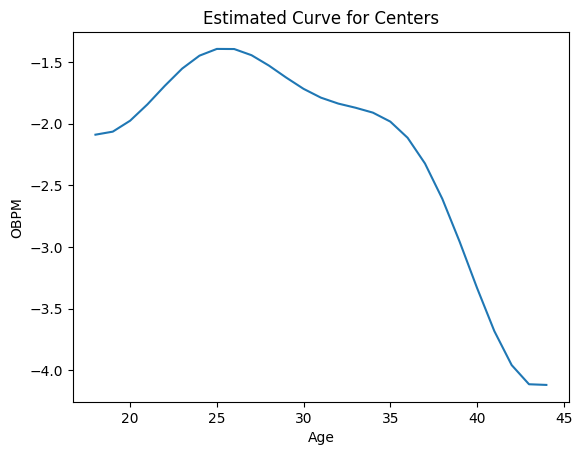

In [113]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

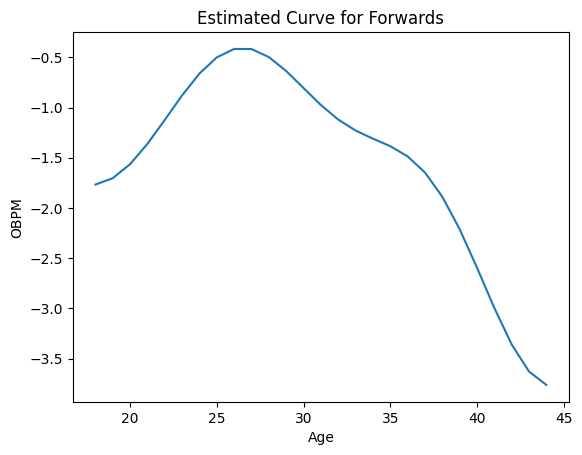

In [114]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

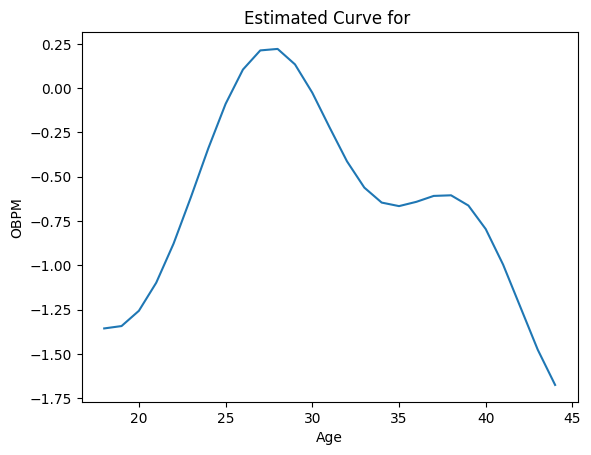

In [108]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")